# Document Clustering with LLM Embeddings

This notebook demonstrates document clustering using state-of-the-art LLM embeddings from sentence-transformers. We'll use pretrained transformer models to generate semantic embeddings and cluster documents based on their meaning.

**Objective**: Cluster text documents using contextual embeddings from pretrained language models, capturing semantic similarity beyond simple keyword matching.

In [1]:
# Installing required libraries
!pip install sentence-transformers scikit-learn umap-learn matplotlib seaborn pandas numpy -q

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

# Setting style
sns.set_style("whitegrid")
np.random.seed(42)

## Loading Document Dataset

Loading a subset of the 20 newsgroups dataset which contains posts from different newsgroup categories. Selecting 4 distinct categories for clustering.

In [2]:
# Loading 20 newsgroups dataset with selected categories
categories = [
    'rec.sport.baseball',
    'sci.space',
    'comp.graphics',
    'talk.politics.guns'
]

print("Loading 20 newsgroups dataset...")
newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')  # Removing metadata
)

documents = newsgroups.data
true_labels = newsgroups.target
category_names = newsgroups.target_names

# Taking subset for faster processing (300 documents)
sample_size = 300
indices = np.random.choice(len(documents), sample_size, replace=False)
documents = [documents[i] for i in indices]
true_labels = true_labels[indices]

print(f"\nDataset loaded successfully!")
print(f"Number of documents: {len(documents)}")
print(f"Categories: {category_names}")
print(f"Category distribution: {np.bincount(true_labels)}")

Loading 20 newsgroups dataset...

Dataset loaded successfully!
Number of documents: 300
Categories: ['comp.graphics', 'rec.sport.baseball', 'sci.space', 'talk.politics.guns']
Category distribution: [82 75 77 66]


## Previewing Sample Documents

Displaying sample documents from each category to observe the content and understand what we're clustering.

In [3]:
# Previewing documents from each category
print("="*80)
print("DOCUMENT PREVIEW: Sample from Each Category")
print("="*80)

for category_id, category_name in enumerate(category_names):
    # Finding first document from this category
    doc_indices = np.where(true_labels == category_id)[0]
    if len(doc_indices) > 0:
        sample_doc = documents[doc_indices[0]]

        print(f"\n{'='*80}")
        print(f"Category: {category_name}")
        print(f"{'='*80}")
        # Showing first 500 characters
        preview = sample_doc[:500].replace('\n', ' ').strip()
        print(f"{preview}...")
        print(f"\n[Document length: {len(sample_doc)} characters]")

# Creating a summary DataFrame
doc_df = pd.DataFrame({
    'Document_ID': range(len(documents)),
    'Category': [category_names[label] for label in true_labels],
    'Length': [len(doc) for doc in documents],
    'Preview': [doc[:100].replace('\n', ' ')[:100] + '...' for doc in documents]
})

print(f"\n{'='*80}")
print("Document Summary Table (First 10 documents)")
print(f"{'='*80}")
print(doc_df.head(10).to_string(index=False))

DOCUMENT PREVIEW: Sample from Each Category

Category: comp.graphics
...

[Document length: 0 characters]

Category: rec.sport.baseball
Wasn't Ron Bloomberg, the former Yankee who got the first base hit by a Designated Hitter, Jewish??...

[Document length: 100 characters]

Category: sci.space
big Capacitor :-)   Real Big  capacitor....

[Document length: 42 characters]

Category: talk.politics.guns
The Associated Press had an article on Monday March 1, I believe, which quoted witnesses as describing BATF agents throwing grenades prior to any gunfire on the part of the Davidians.         It was among the first of a crop of different, mutually exclusive descriptions....

[Document length: 280 characters]

Document Summary Table (First 10 documents)
 Document_ID           Category  Length                                                                                                 Preview
           0 rec.sport.baseball     100  Wasn't Ron Bloomberg, the former Yankee who got the first

## Loading Pretrained LLM Embedding Model

Loading the 'all-MiniLM-L6-v2' model from sentence-transformers. This is a lightweight but powerful model that generates 384-dimensional semantic embeddings.

In [4]:
# Loading pretrained sentence transformer model
model_name = 'all-MiniLM-L6-v2'
print(f"Loading pretrained model: {model_name}...")
print("This may take a moment on first run as the model is downloaded.")

embedding_model = SentenceTransformer(model_name)

print(f"\nModel loaded successfully!")
print(f"Model: {model_name}")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")
print(f"Max sequence length: {embedding_model.max_seq_length}")

Loading pretrained model: all-MiniLM-L6-v2...
This may take a moment on first run as the model is downloaded.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Model loaded successfully!
Model: all-MiniLM-L6-v2
Embedding dimension: 384
Max sequence length: 256


## Generating Document Embeddings

Converting each document into a dense vector representation using the pretrained model. These embeddings capture semantic meaning and context.

In [5]:
# Generating embeddings for all documents
print("Generating embeddings for all documents...")
print("This may take 1-2 minutes depending on document length.")

embeddings = embedding_model.encode(
    documents,
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True
)

print(f"\nEmbeddings generated successfully!")
print(f"Embedding matrix shape: {embeddings.shape}")
print(f"Number of documents: {embeddings.shape[0]}")
print(f"Embedding dimension: {embeddings.shape[1]}")

# Showing sample embedding
print(f"\nSample embedding (first 10 dimensions): {embeddings[0][:10]}")

Generating embeddings for all documents...
This may take 1-2 minutes depending on document length.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]


Embeddings generated successfully!
Embedding matrix shape: (300, 384)
Number of documents: 300
Embedding dimension: 384

Sample embedding (first 10 dimensions): [ 0.02744681  0.08002938 -0.04206869  0.03003167 -0.07258312  0.00903242
  0.03019635  0.03890629 -0.00569593  0.04126951]


## Clustering Document Embeddings

Applying K-Means clustering on the document embeddings to group semantically similar documents together.

In [6]:
# Applying K-Means clustering
n_clusters = 4

print(f"Applying K-Means clustering with k={n_clusters}...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Calculating metrics
silhouette_avg = silhouette_score(embeddings, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print(f"\n{'='*50}")
print(f"Document Clustering Results")
print(f"{'='*50}")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution: {np.bincount(cluster_labels)}")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Inertia: {kmeans.inertia_:.2f}")

Applying K-Means clustering with k=4...

Document Clustering Results
Number of clusters: 4
Cluster distribution: [72 64 95 69]
Silhouette Score: 0.065
Adjusted Rand Index: 0.657
Inertia: 246.43


## Dimensionality Reduction for Visualization

Reducing high-dimensional embeddings (384D) to 2D using UMAP for visualization while preserving the semantic structure.

In [7]:
# Reducing dimensions for visualization using UMAP
print("Reducing dimensions with UMAP for visualization...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = reducer.fit_transform(embeddings)

print(f"Dimensionality reduction complete!")
print(f"Original shape: {embeddings.shape}")
print(f"Reduced shape: {embeddings_2d.shape}")

Reducing dimensions with UMAP for visualization...
Dimensionality reduction complete!
Original shape: (300, 384)
Reduced shape: (300, 2)


## Visualizing Document Clusters

Plotting the clustered documents in 2D space, comparing predicted clusters with true categories.

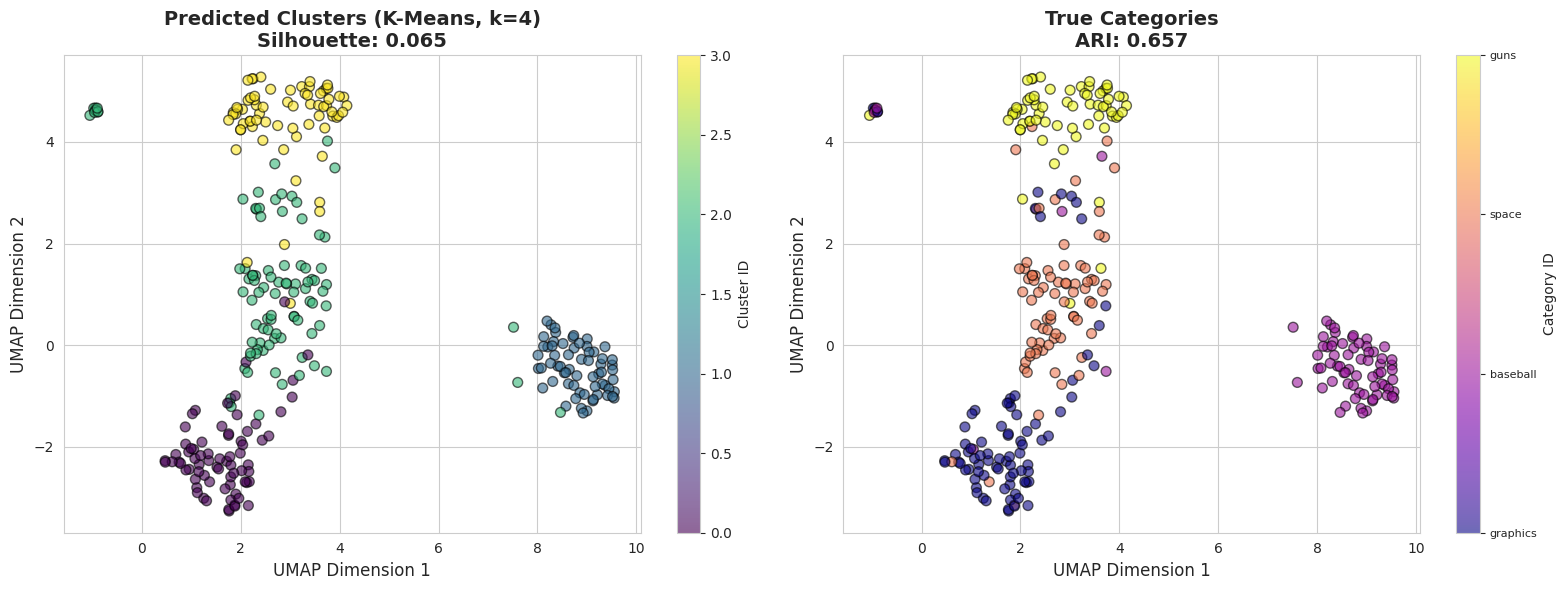

In [8]:
# Visualizing clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Predicted clusters
scatter1 = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=cluster_labels, cmap='viridis',
                          alpha=0.6, edgecolors='k', s=50)
axes[0].set_title(f'Predicted Clusters (K-Means, k={n_clusters})\nSilhouette: {silhouette_avg:.3f}',
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Subplot 2: True categories
scatter2 = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=true_labels, cmap='plasma',
                          alpha=0.6, edgecolors='k', s=50)
axes[1].set_title(f'True Categories\nARI: {ari:.3f}',
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
cbar = plt.colorbar(scatter2, ax=axes[1], label='Category ID')
cbar.set_ticks(range(len(category_names)))
cbar.set_ticklabels([name.split('.')[-1][:10] for name in category_names], fontsize=8)

plt.tight_layout()
plt.show()

## Analyzing Cluster Composition

Examining which true categories ended up in each predicted cluster to understand the clustering quality.

CLUSTER COMPOSITION ANALYSIS


Cluster 0:
----------------------------------------
Total documents: 72
Category breakdown:
  comp.graphics                 :  66 ( 91.7%)
  rec.sport.baseball            :   1 (  1.4%)
  sci.space                     :   5 (  6.9%)
  talk.politics.guns            :   0 (  0.0%)
Dominant category: comp.graphics

Cluster 1:
----------------------------------------
Total documents: 64
Category breakdown:
  comp.graphics                 :   0 (  0.0%)
  rec.sport.baseball            :  64 (100.0%)
  sci.space                     :   0 (  0.0%)
  talk.politics.guns            :   0 (  0.0%)
Dominant category: rec.sport.baseball

Cluster 2:
----------------------------------------
Total documents: 95
Category breakdown:
  comp.graphics                 :  16 ( 16.8%)
  rec.sport.baseball            :   9 (  9.5%)
  sci.space                     :  66 ( 69.5%)
  talk.politics.guns            :   4 (  4.2%)
Dominant category: sci.space

Cluster 3:
---------------

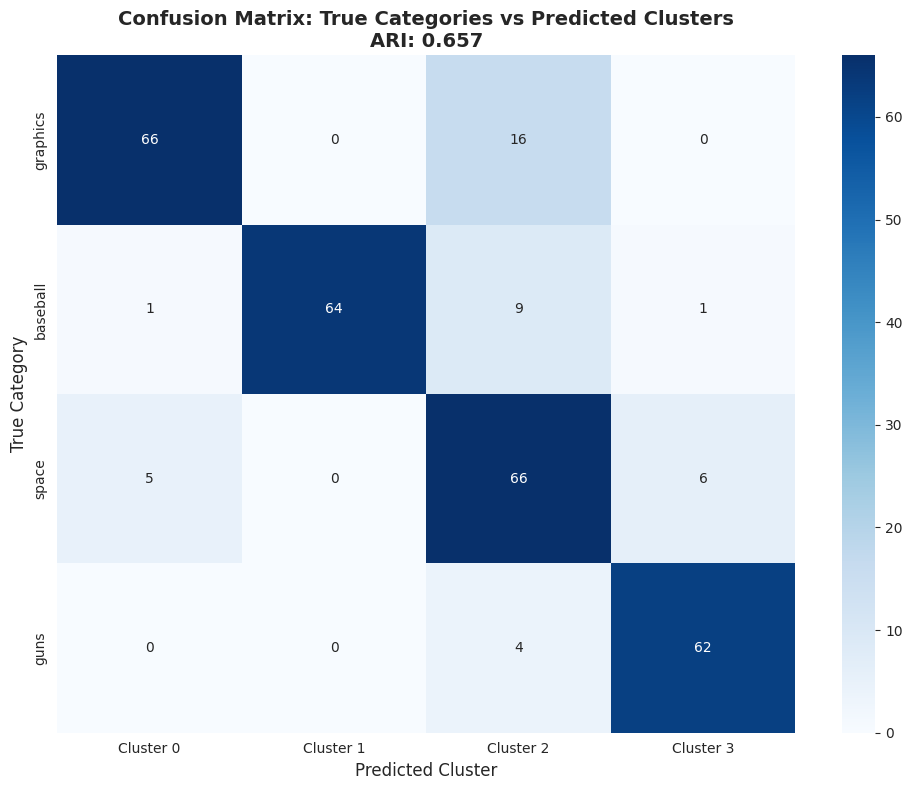

In [9]:
# Analyzing cluster composition
print(f"{'='*80}")
print("CLUSTER COMPOSITION ANALYSIS")
print(f"{'='*80}\n")

for cluster_id in range(n_clusters):
    print(f"\nCluster {cluster_id}:")
    print("-" * 40)

    # Finding documents in this cluster
    cluster_mask = cluster_labels == cluster_id
    cluster_true_labels = true_labels[cluster_mask]

    # Counting categories in this cluster
    print(f"Total documents: {cluster_mask.sum()}")
    print("Category breakdown:")
    for cat_id, cat_name in enumerate(category_names):
        count = (cluster_true_labels == cat_id).sum()
        percentage = (count / cluster_mask.sum()) * 100 if cluster_mask.sum() > 0 else 0
        print(f"  {cat_name:30s}: {count:3d} ({percentage:5.1f}%)")

    # Showing dominant category
    if cluster_mask.sum() > 0:
        dominant_cat = np.bincount(cluster_true_labels).argmax()
        print(f"Dominant category: {category_names[dominant_cat]}")

# Creating confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, cluster_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            yticklabels=[name.split('.')[-1] for name in category_names])
plt.title(f'Confusion Matrix: True Categories vs Predicted Clusters\nARI: {ari:.3f}',
         fontsize=14, fontweight='bold')
plt.xlabel('Predicted Cluster', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.tight_layout()
plt.show()

## Sample Documents from Each Cluster

Displaying representative documents from each cluster to understand what topics/themes were discovered.

In [10]:
# Showing sample documents from each cluster
print(f"{'='*80}")
print("SAMPLE DOCUMENTS FROM EACH CLUSTER")
print(f"{'='*80}\n")

for cluster_id in range(n_clusters):
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")

    # Finding documents in this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    # Showing 2 sample documents
    for i, doc_idx in enumerate(cluster_indices[:2]):
        true_cat = category_names[true_labels[doc_idx]]
        doc_preview = documents[doc_idx][:300].replace('\n', ' ').strip()

        print(f"\nSample {i+1} (True category: {true_cat}):")
        print("-" * 80)
        print(f"{doc_preview}...")

print(f"\n{'='*80}")
print("Document clustering with LLM embeddings complete!")
print(f"Achieved Silhouette Score: {silhouette_avg:.3f}")
print(f"Achieved Adjusted Rand Index: {ari:.3f}")
print(f"{'='*80}")

SAMPLE DOCUMENTS FROM EACH CLUSTER


CLUSTER 0

Sample 1 (True category: comp.graphics):
--------------------------------------------------------------------------------
Appsoft Image is available for NeXTStep. It is a image processing program similar to Adobe Photoshop. It is reviewed in the April '93 issue of Publish! Magazine....

Sample 2 (True category: comp.graphics):
--------------------------------------------------------------------------------
I sure did use version 3.2. It works fine with most software but NOT with Animator Pro and that one is quite important to me. Pretty useless program without that thing working IMHO. So I hope the author can fix that.  /Daniel......

CLUSTER 1

Sample 1 (True category: rec.sport.baseball):
--------------------------------------------------------------------------------
Wasn't Ron Bloomberg, the former Yankee who got the first base hit by a Designated Hitter, Jewish??...

Sample 2 (True category: rec.sport.baseball):
---------------------